# Connect to Drive
Add [this Google folder](https://drive.google.com/drive/folders/1K54qqwYtk1ADJlkptJNF-FfyjQ7R6KGC?usp=sharing) to your drive then adjust the paths in the `current_directory` variable 

In [1]:
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
current_directory = "/content/drive/MyDrive/AI/Trained models"
os.chdir("/content/drive/MyDrive/AI/Trained models")

# Load holdout data predictions from the different models for evaluation

In [8]:
import pandas as pd
df = pd.read_csv("holdout_final_with_bert_predictions_and_svm_predictions.csv")
preds_df = df.drop(columns=["response","Label","GLTR Category 1","GLTR Category 3","sum_mistakes","TextBlob_Subjectivity","Formality Score"], axis=1)
preds_df = preds_df.rename(columns={'BertClassifier_Predictions':"BERT", "svm_tfidf_predictions":"SVM_TFIDF", "svm_glove_predictions":"SVM_GLOVE"})
y_true = df["Label"].values
preds_df.head(1)

,CNN_GLTR,BERT,SVM_TFIDF,SVM_GLOVE
0,0.505068,0.46252,0,1


# Evaluate Accuracy

To be more sure that the text is AI-written, the threshold to classify as AI is if the probability of being AI is more than 0.6

In [5]:
from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score  
import numpy as np
def evaluate(pred, y_true, threshold):
  y_pred = np.array(pred)
  discrete = (y_pred > threshold).astype("int32")
  accuracy = accuracy_score(y_true, discrete)
  f1score = f1_score(y_true, discrete)
  roc_auc = roc_auc_score(y_true,discrete)
  print(classification_report(y_true,discrete, target_names=["Human", "ChatGPT"]))
  return [accuracy, roc_auc, f1score]

In [9]:
col_perf_lst = []
threshold = 0.6
for clf in preds_df.columns:
  print(clf)
  pred = preds_df[clf].tolist()
  eval_result = evaluate(pred, y_true,threshold)
  result_lst = [clf]
  result_lst.extend(eval_result)
  col_perf_lst.append(result_lst)

col_perf_lst.sort(key=lambda a:  (a[1], a[2], a[3]), reverse=True)
col_perf_lst

CNN_GLTR
              precision    recall  f1-score   support

       Human       0.86      0.78      0.82      4999
     ChatGPT       0.80      0.87      0.84      4999

    accuracy                           0.83      9998
   macro avg       0.83      0.83      0.83      9998
weighted avg       0.83      0.83      0.83      9998

BERT
              precision    recall  f1-score   support

       Human       0.87      0.96      0.91      4999
     ChatGPT       0.95      0.86      0.91      4999

    accuracy                           0.91      9998
   macro avg       0.91      0.91      0.91      9998
weighted avg       0.91      0.91      0.91      9998

SVM_TFIDF
              precision    recall  f1-score   support

       Human       0.94      0.98      0.96      4999
     ChatGPT       0.98      0.94      0.96      4999

    accuracy                           0.96      9998
   macro avg       0.96      0.96      0.96      9998
weighted avg       0.96      0.96      0.96      9

[['SVM_TFIDF', 0.958491698339668, 0.958491698339668, 0.9577263929917491],
 ['BERT', 0.909881976395279, 0.909881976395279, 0.9052476601114733],
 ['CNN_GLTR', 0.8273654730946189, 0.8273654730946189, 0.835179526355997],
 ['SVM_GLOVE', 0.6517303460692139, 0.6517303460692139, 0.613111111111111]]

# Check if models are correlated by checking if their errors are correlated

High correlation is expected given that these models were trained on similar data and have similar model structure. Furthermore, each model differed mainly by 1 feature, which might not have significantly diverisfied the models given that the text features would still dominate.

In [10]:
from sklearn.metrics import log_loss
residual_col_name_lst = []
for col in preds_df:
  new_col_name = col + "_Residuals"
  residual_col_name_lst.append(new_col_name)
  preds_df[new_col_name] = y_true - preds_df[col].tolist()

residual_df = preds_df[residual_col_name_lst]

SVM_GLOVE and CNN_GLTR are more correlated.

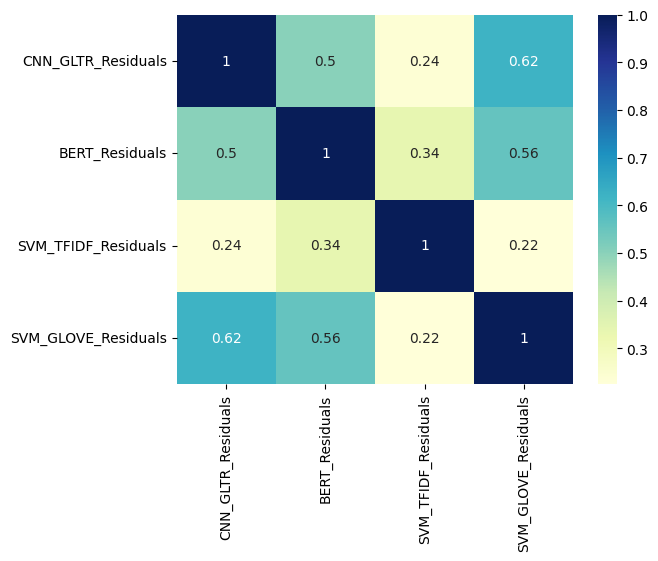

In [11]:
import seaborn as sb
corr = residual_df.corr()
dataplot = sb.heatmap(corr, cmap="YlGnBu", annot=True)

# Final Model Choices and Rationale

Out of the correlated groups, we will pick the model with highest accuracy/f1/roc-auc on holdout dataset. We will choose based on the holdout dataset as this is unseen data by all the models.

```
[['SVM_TFIDF', 0.958491698339668, 0.958491698339668, 0.9577263929917491],
 ['BERT', 0.909881976395279, 0.909881976395279, 0.9052476601114733],
 ['CNN_GLTR', 0.8273654730946189, 0.8273654730946189, 0.835179526355997],
 ['SVM_GLOVE', 0.6517303460692139, 0.6517303460692139, 0.613111111111111]]

```

Chosen models: BERT, CNN, SVM_TFIDF

# Grid Search To Get Optimal Weights


In [12]:
from itertools import product
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score  

# normalize a vector to have unit norm
def normalize(weights):
 # calculate l1 vector norm
 result = np.linalg.norm(weights, 1)
 # check for a vector of all zeros
 if result == 0.0:
  return weights
 # return normalized vector (unit norm)
 return weights / result

#prediction compiled list is a list of prediction from each model for each test data point
def get_scores(prediction_compiled_list, threshold, y_true, weights):
  #Apply weights to predictions to get weighted average
  yhats = np.array(prediction_compiled_list)
  avg = np.average(yhats,axis=1,weights=weights)
  #Convert probabilities to 0 or 1 classification outcome
  discrete = (avg > threshold).astype("int32")
  return {"accuracy":accuracy_score(discrete, y_true), "f1":f1_score(discrete, y_true),"roc-auc":roc_auc_score(discrete,y_true)}

#preds is a list of prediction from each model for each test data point
def grid_search(num_models, preds, testy, threshold):
  tracker = []
  w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  # iterate all possible combinations (cartesian product)
  for weights in product(w, repeat=num_models):
    # skip if all weights are equal
    if len(set(weights)) == 1:
      continue
    # hack, normalize weight vector
    weights = normalize(weights)
    # evaluate weights
    score_dict = get_scores(preds, threshold, testy, weights)
    accuracy = score_dict["accuracy"]
    f1 = score_dict["f1"] 
    roc_auc = score_dict["roc-auc"]
    tracker.append((accuracy, f1, roc_auc, weights))
  return tracker

#outputs is a a list of predictions from each model [[model_1_preds], [model_2_preds]]
#we want to output [[model_1_pred_for_row1, model_2_pred_for_row1], [...]]
def get_prediction_compiled_list(outputs):
  prediction_compiled_lst = []
  num_rows_predicted = len(outputs[0])
  for i in range(num_rows_predicted):
    prediction_lst = []
    for output in outputs:
      prediction_lst.append(output[i])
    prediction_compiled_lst.append(prediction_lst)
  return prediction_compiled_lst
    

In [13]:
outputs = [preds_df['BERT'], preds_df['CNN_GLTR'], preds_df['SVM_TFIDF']]

In [14]:
threshold = 0.6
num_models = 3
preds = get_prediction_compiled_list(outputs)
tracker = grid_search(num_models, preds, y_true, threshold)

Sort by 1. Prioritise weights that do not zero out weights for any model 2. Prioritise weights that give higher accuracy followed by ROC_AUC then F1 Score

In [15]:
#sort by accuracy, roc_auc score, f1 score then choose arrays that have more models with non-zero weights for diversification
#as we are using a holdout set of small size

def get_count_of_weights_above_zero(weights):
  count = 0
  for weight in weights:
    if weight > 0:
      count += 1
  return count

tracker.sort(key=lambda a:  (get_count_of_weights_above_zero(a[3]),a[0], a[2], a[1],), reverse=True)
print(tracker[:10])
best_weights = tracker[0][3]
best_weights

[(0.958491698339668, 0.9577263929917491, 0.9590935536141016, array([0.25, 0.25, 0.5 ])), (0.958491698339668, 0.9577263929917491, 0.9590935536141016, array([0.2, 0.2, 0.6])), (0.958491698339668, 0.9577263929917491, 0.9590935536141016, array([0.16666667, 0.16666667, 0.66666667])), (0.958491698339668, 0.9577263929917491, 0.9590935536141016, array([0.14285714, 0.14285714, 0.71428571])), (0.958491698339668, 0.9577263929917491, 0.9590935536141016, array([0.125, 0.125, 0.75 ])), (0.958491698339668, 0.9577263929917491, 0.9590935536141016, array([0.11111111, 0.11111111, 0.77777778])), (0.958491698339668, 0.9577263929917491, 0.9590935536141016, array([0.1, 0.1, 0.8])), (0.958491698339668, 0.9577263929917491, 0.9590935536141016, array([0.09090909, 0.09090909, 0.81818182])), (0.958491698339668, 0.9577263929917491, 0.9590935536141016, array([0.08333333, 0.08333333, 0.83333333])), (0.958491698339668, 0.9577263929917491, 0.9590935536141016, array([0.16666667, 0.33333333, 0.5       ]))]


array([0.25, 0.25, 0.5 ])

Test out the optimal weights found
In order of accuracy, ROC_AUC and F1_Score, the models individually did: 
```
 ['SVM_TFIDF', 0.958491698339668, 0.958491698339668, 0.9577263929917491],
 ['BERT', 0.909881976395279, 0.909881976395279, 0.9052476601114733],
 ['CNN_GLTR', 0.8273654730946189, 0.8273654730946189, 0.835179526355997],

```
Together, with weights of [0.25, 0.25, 0.5] for BERT, CNN and SVM respectively, the ensemble achieved:

Accuracy:0.96

ROC_AUC:0.96

F1_Score:0.96

Even though the SVM_TFIDF had comparable individual performance, this was one a small holdout dataset of 1000 pairs of human and AI written responses. We also want to aim for variance by ensuring that the ensemble can generalise well. This could be done with the help of BERT and CNN_GLTR which are uncorrelated and high-performing as well.